# Baseline


In [ ]:
import json
import os

# Function to load JSON from a file
def load_json(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

# Function to load all JSONs (train, val, test, mapping) into respective variables
def load_all_jsons(folder_path):
    train = load_json(folder_path, "train.json")
    val = load_json(folder_path, "val.json")
    test = load_json(folder_path, "test.json")
    mapping = load_json(folder_path, "mapping.json")

    return train, val, test, mapping

# Example usage:
output_folder = "../data/splits"
train, val, test, mapping = load_all_jsons(output_folder)

In [ ]:
 import numpy as np

x_train = [record['text'] for record in train]
y_train = np.asarray([record['label'] for record in train])

x_test = [record['text'] for record in test]
y_test = np.asarray([record['label'] for record in test])

In [ ]:
# prompt: convert x_test and y_test to test_df

import pandas as pd
test_df = pd.DataFrame({
    'Comment': x_test,
    'Validated_Labels': y_test
})


In [ ]:
test_df["Validated_Labels"].value_counts()

,count
Validated_Labels,
3,79
2,40
1,21
0,19


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


preprocessing = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

print("Preprocessing training data...")
train_preprocessed = preprocessing.fit_transform(x_train)

print("Preprocessing test data...")
test_preprocessed = preprocessing.transform(x_test)

Preprocessing training data...
Preprocessing test data...


In [ ]:
print("Training data shape:", train_preprocessed.shape)
print("Test data shape:", test_preprocessed.shape)

Training data shape: (593, 1822)
Test data shape: (159, 1822)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

nb_classifier = MultinomialNB()
svm_classifier = LinearSVC()
lr_classifier = LogisticRegression(multi_class="ovr")

print("Training Naive Bayes classifier...")
nb_classifier.fit(train_preprocessed, y_train)

print("Training SVM classifier...")
svm_classifier.fit(train_preprocessed, y_train)

print("Training Logistic Regression classifier...")
lr_classifier.fit(train_preprocessed, y_train)

Training Naive Bayes classifier...
Training SVM classifier...
Training Logistic Regression classifier...


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LogisticRegression(multi_class='ovr')

In [ ]:
nb_predictions = nb_classifier.predict(test_preprocessed)
svm_predictions = svm_classifier.predict(test_preprocessed)
lr_predictions = lr_classifier.predict(test_preprocessed)

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

parameters = {'C': np.logspace(0, 3, 10)}
parameters = {'C': [0.1, 1, 10, 100, 1000]}

print("Grid search for SVM")
svm_best = GridSearchCV(svm_classifier, parameters, cv=3, verbose=1)
svm_best.fit(train_preprocessed, y_train)

print("Grid search for logistic regression")
lr_best = GridSearchCV(lr_classifier, parameters, cv=3, verbose=1)
lr_best.fit(train_preprocessed, y_train)

Grid search for SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: Futu

Grid search for logistic regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=LogisticRegression(multi_class='ovr'),
             param_grid={'C': [0.1, 1, 10, 100, 1000]}, verbose=1)

In [ ]:
print("Best SVM Parameters")
print(svm_best.best_params_)

print("Best LR parameters:")
print(lr_best.best_params_)

Best SVM Parameters
{'C': 1}
Best LR parameters:
{'C': 10}


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = LinearSVC(C=1)

calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')

calibrated_clf.fit(train_preprocessed, y_train)

y_prob = calibrated_clf.predict_proba(test_preprocessed)

print(classification_report(y_test, calibrated_clf.predict(test_preprocessed)))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67        19
           1       0.50      0.33      0.40        21
           2       0.53      0.40      0.46        40
           3       0.63      0.78      0.70        79

    accuracy                           0.61       159
   macro avg       0.59      0.54      0.56       159
weighted avg       0.60      0.61      0.60       159



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: Futu

In [ ]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 26})  # Increase font size here
    plt.xlabel('Predicted Label', fontsize=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=20, fontweight='bold')
    plt.xticks(fontsize=18)  # Increase x-axis tick label size and make bold
    plt.yticks(fontsize=18)  # Increase y-axis tick label size and make bold

    plt.show()

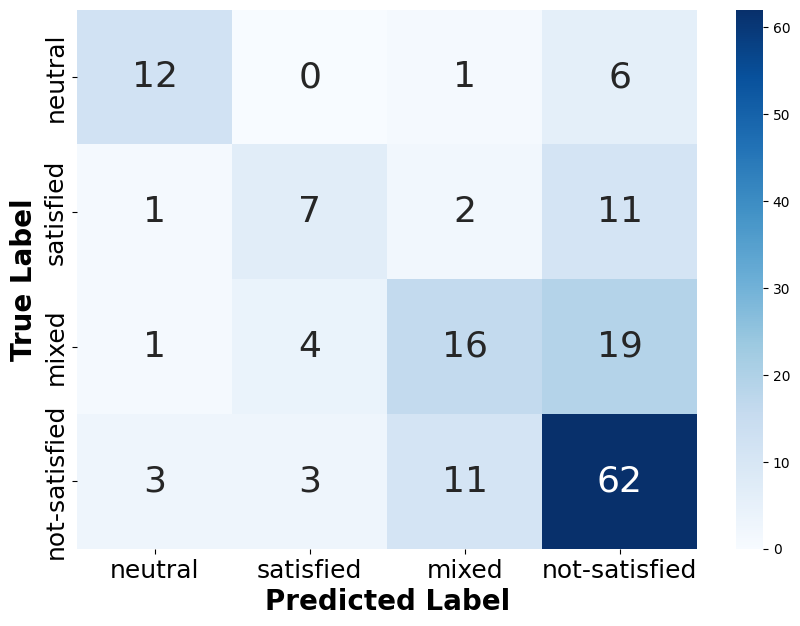

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, calibrated_clf.predict(test_preprocessed), labels=[0, 1, 2, 3])
plot_confusion_matrix(cm, labels=['neutral', 'satisfied', 'mixed', 'not-satisfied'])


In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(C=10)

clf_lr.fit(train_preprocessed, y_train)

y_prob_lr = clf_lr.predict_proba(test_preprocessed)

print(classification_report(y_test, clf_lr.predict(test_preprocessed)))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63        19
           1       0.45      0.24      0.31        21
           2       0.59      0.55      0.57        40
           3       0.64      0.77      0.70        79

    accuracy                           0.62       159
   macro avg       0.59      0.53      0.55       159
weighted avg       0.61      0.62      0.61       159



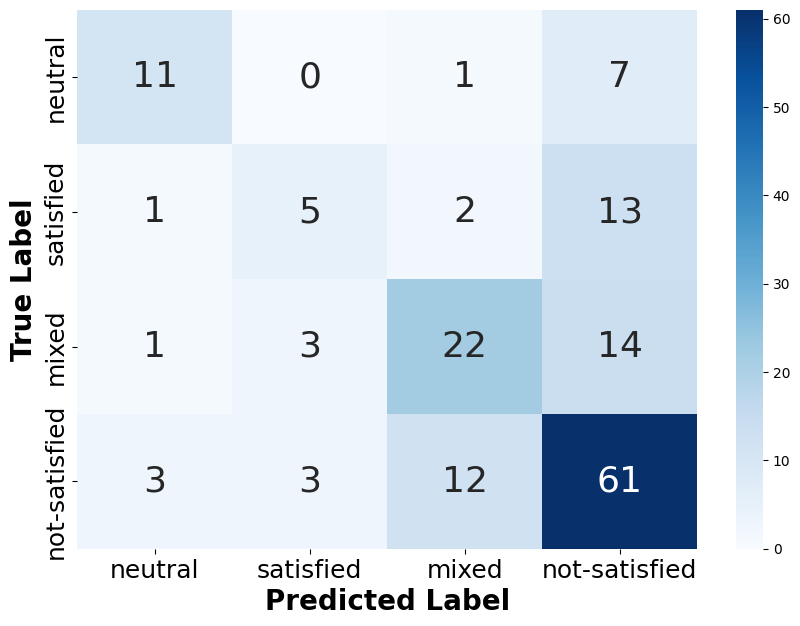

In [ ]:
cm = confusion_matrix(y_test, clf_lr.predict(test_preprocessed), labels=[0, 1, 2, 3])
plot_confusion_matrix(cm, labels=['neutral', 'satisfied', 'mixed', 'not-satisfied'])